Training LSTM Model

<!--This File is for training the LSTM model for comparing cv data with the statement database to see if it is a good cv statement  -->

In [9]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import numpy as np

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rache\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.0005
EMBEDDING_DIM = 110
HIDDEN_DIM = 256

In [11]:
# Load dataset
df = pd.read_csv('cv_statements_dataset.csv')

In [12]:
# Tokenise Text: use library nltk to tokenise the text into all lowercasing word, flatten into a list all_tokens
# Count the tokens:  to count the occurence of the tokenised words, and order them based on their occurence
# for larger scale later we will keep the most appeared words for keeping the model computable
# Make the Dictionary: to store the most occured vocabulary 

def tokenize(text):
    return word_tokenize(text.lower())

df['tokens'] = df['statement'].apply(tokenize)

all_tokens = [token for tokens in df['tokens'] for token in tokens]
token_counts = Counter(all_tokens)
vocab = {token: idx+2 for idx, (token, _) in enumerate(token_counts.items())}

# Handel when tokens not found uses id 1 for LSTM 
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

def encode(tokens):
    return [vocab.get(token, vocab['<UNK>']) for token in tokens]

df['input_ids'] = df['tokens'].apply(encode)
MAX_LEN = max(df['input_ids'].apply(len))

def pad_sequence(seq, max_len=MAX_LEN):
    return seq + [vocab['<PAD>']] * (max_len - len(seq))

df['input_ids'] = df['input_ids'].apply(pad_sequence)

In [13]:
# Prepare and split the dataset into testing and training data

class CVStatementDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)

X_train, X_test, y_train, y_test = train_test_split(df['input_ids'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42)

train_dataset = CVStatementDataset(X_train, y_train)
test_dataset = CVStatementDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [14]:
# LSTM Model 

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab['<PAD>'])
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        hidden_cat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1) 
        dropped = self.dropout(hidden_cat)
        output = self.fc(dropped)
        return self.sigmoid(output)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMClassifier(vocab_size=len(vocab), embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [15]:
# Training the Data

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/100 - Loss: 0.2029
Epoch 2/100 - Loss: 0.0005
Epoch 3/100 - Loss: 0.0002
Epoch 4/100 - Loss: 0.0001
Epoch 5/100 - Loss: 0.0001
Epoch 6/100 - Loss: 0.0001
Epoch 7/100 - Loss: 0.0001
Epoch 8/100 - Loss: 0.0001
Epoch 9/100 - Loss: 0.0000
Epoch 10/100 - Loss: 0.0000
Epoch 11/100 - Loss: 0.0000
Epoch 12/100 - Loss: 0.0000
Epoch 13/100 - Loss: 0.0000
Epoch 14/100 - Loss: 0.0000
Epoch 15/100 - Loss: 0.0000
Epoch 16/100 - Loss: 0.0000
Epoch 17/100 - Loss: 0.0000
Epoch 18/100 - Loss: 0.0000
Epoch 19/100 - Loss: 0.0000
Epoch 20/100 - Loss: 0.0000
Epoch 21/100 - Loss: 0.0000
Epoch 22/100 - Loss: 0.0000
Epoch 23/100 - Loss: 0.0000
Epoch 24/100 - Loss: 0.0000
Epoch 25/100 - Loss: 0.0000
Epoch 26/100 - Loss: 0.0000
Epoch 27/100 - Loss: 0.0000
Epoch 28/100 - Loss: 0.0000
Epoch 29/100 - Loss: 0.0000
Epoch 30/100 - Loss: 0.0000
Epoch 31/100 - Loss: 0.0000
Epoch 32/100 - Loss: 0.0000
Epoch 33/100 - Loss: 0.0000
Epoch 34/100 - Loss: 0.0000
Epoch 35/100 - Loss: 0.0000
Epoch 36/100 - Loss: 0.0000
E

In [16]:
# Save Model for FastAPI
torch.save(model.state_dict(), 'lstm_cv_model.pth')

import pickle
with open('vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)

print("Model saved")

Model saved



Training Accuracy: 1.0000


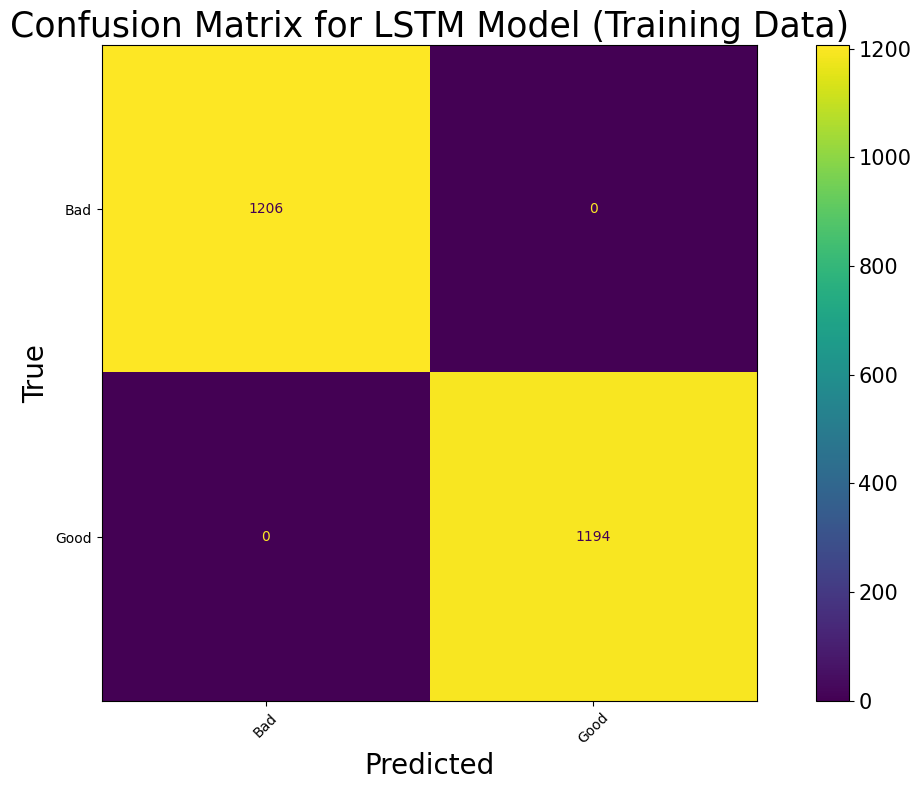

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).squeeze()
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Training Accuracy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
train_accuracy = (all_preds == all_labels).mean()
print(f"\nTraining Accuracy: {train_accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots(figsize=(12, 8))

def plot_confusion_matrix(ax, matrix, labels, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=labels)
    cbar = disp.plot(cmap='viridis', ax=ax, colorbar=True).im_.colorbar
    cbar.ax.tick_params(labelsize=15)
    ax.set_title(title, fontsize=25)
    ax.set_xlabel("Predicted", fontsize=20)
    ax.set_ylabel("True", fontsize=20)
    ax.set_xticklabels(labels, rotation=45)

plot_confusion_matrix(ax, conf_matrix, labels=["Bad", "Good"], title="Confusion Matrix for LSTM Model (Training Data)")

plt.tight_layout()
plt.show()



In [24]:
#Visualize Result
model.load_state_dict(torch.load('lstm_cv_model.pth'))
model.to(device)
with open('vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

def predict_statement(statement, model, vocab, max_len=MAX_LEN):
    model.eval()
    tokens = word_tokenize(statement.lower())
    input_ids = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    if len(input_ids) < max_len:
        input_ids += [vocab['<PAD>']] * (max_len - len(input_ids))
    else:
        input_ids = input_ids[:max_len]
    input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)
    
    with torch.no_grad():
        output = model(input_tensor).squeeze().item()
    
    return output

good_statements = [
    "Led a cross-functional team to deliver a project ahead of schedule.",
    "Developed an AI-based system to improve customer service response times.",
    "Managed a $1M budget while reducing costs by 15%.",
    "Presented research findings at an international conference.",
    "Designed and implemented a secure database system for a healthcare company.",
    "Achieved a 30% increase in sales through strategic marketing initiatives.",
    "Authored several technical papers published in peer-reviewed journals.",
    "Organized and led weekly team meetings to improve communication.",
    "Optimized website performance, reducing load times by 40%.",
    "Created detailed project documentation and user manuals."
]

bad_statements = [
    "I like working sometimes if the team is nice.",
    "I have some knowledge about computers maybe.",
    "Just looking for any opportunity, not picky.",
    "I'm not really sure what I want to do yet.",
    "Helped out with various things but no big projects.",
    "Prefer a job where I don't have to do too much.",
    "Did many things in previous job but don't remember exactly.",
    "Looking for an easy job with flexible hours."
    "I like to draw."
    "I love animals."
]

results = []

for statement in good_statements:
    score = predict_statement(statement, model, vocab)
    results.append({
        'statement': statement,
        'score': score,
        'true_label': 'Good',
        'predicted_label': 'Good' if score > 0.5 else 'Bad'
    })

for statement in bad_statements:
    score = predict_statement(statement, model, vocab)
    results.append({
        'statement': statement,
        'score': score,
        'true_label': 'Bad',
        'predicted_label': 'Good' if score > 0.5 else 'Bad'
    })

df_results = pd.DataFrame(results)
df_results['score'] = df_results['score'].apply(lambda x: round(x, 4))
print(df_results[['statement', 'score', 'true_label', 'predicted_label']])




                                            statement   score true_label  \
0   Led a cross-functional team to deliver a proje...  1.0000       Good   
1   Developed an AI-based system to improve custom...  0.9829       Good   
2   Managed a $1M budget while reducing costs by 15%.  1.0000       Good   
3   Presented research findings at an internationa...  0.9574       Good   
4   Designed and implemented a secure database sys...  1.0000       Good   
5   Achieved a 30% increase in sales through strat...  0.9820       Good   
6   Authored several technical papers published in...  1.0000       Good   
7   Organized and led weekly team meetings to impr...  1.0000       Good   
8   Optimized website performance, reducing load t...  1.0000       Good   
9   Created detailed project documentation and use...  0.9913       Good   
10      I like working sometimes if the team is nice.  0.0000        Bad   
11       I have some knowledge about computers maybe.  0.0000        Bad   
12       Jus